**Rozdział 15. Autokodery**

_Notatnik ten zawiera przykładowy kod i rozwiązania ćwiczeń opisane w rozdziale 15._

# Konfiguracja

Upewnijmy się najpierw, że notatnik ten będzie działał w środowiskach Python 2 i 3, importujmy kilka powszechnie stosowanych modułów, upewnijmy się, że moduł MatplotLib będzie prawidłowo tworzył wykresy, a także przygotujmy funkcję zapisującą rysunki:

In [1]:
# Obsługa środowisk Python 2 i Python 3
from __future__ import division, print_function, unicode_literals

# Importowanie popularnych modułów
import numpy as np
import os
import sys

# W celu zachowania powtarzalności wyników w kolejnych przebiegach
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# Generowanie ładnych wykresów
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Lokacja, w której będą zapisywane rysunki
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "autokodery"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "rysunki", CHAPTER_ID, fig_id + ".png")
    print("Zapisywanie rysunku", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

Dwie funkcje pozwalające na rysowanie wykresów obrazów o rozmiarze 28x28 pikseli i w odcieniach szarości:

In [2]:
def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")
    plt.axis("off")

In [3]:
def plot_multiple_images(images, n_rows, n_cols, pad=2):
    images = images - images.min()  # jeśli minimum == 0, to uzupełnianie zerami przyjmuje biały kolor
    w,h = images.shape[1:]
    image = np.zeros(((w+pad)*n_rows+pad, (h+pad)*n_cols+pad))
    for y in range(n_rows):
        for x in range(n_cols):
            image[(y*(h+pad)+pad):(y*(h+pad)+pad+h),(x*(w+pad)+pad):(x*(w+pad)+pad+w)] = images[y*n_cols+x]
    plt.imshow(image, cmap="Greys", interpolation="nearest")
    plt.axis("off")

# Analiza PCA wraz z autokoderem liniowym

Tworzymy zbiór trójwymiarowych danych:

In [4]:
import numpy.random as rnd

rnd.seed(4)
m = 200
w1, w2 = 0.1, 0.3
noise = 0.1

angles = rnd.rand(m) * 3 * np.pi / 2 - 0.5
data = np.empty((m, 3))
data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * rnd.randn(m) / 2
data[:, 1] = np.sin(angles) * 0.7 + noise * rnd.randn(m) / 2
data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * rnd.randn(m)

Normalizujemy dane:

In [5]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(data[:100])
X_test = scaler.transform(data[100:])

Teraz zbudujmy autokoder...

Uwaga: w książce wykorzystywana jest funkcja `fully_connected()` znajdująca się module `tensorflow.contrib.layers` zamiast funkcji `dense()` stanowiącej część modułu `tf.layers`, który nie istniał w trakcie pisania rozdziału. Zalecamy stosowanie nowej funkcji, ponieważ wszelkie elementy modułu `contrib` mogą być modyfikowane lub usuwane bez uprzedzenia, natomiast moduł `tf.layers` jest częścią oficjalnego interfejsu API. Jak się niebawem przekonamy, stosowany przez nas kod pozostaje w większości niezmieniony.

Głównymi różnicami istotnymi z perspektywy tego rozdziału są:
* parametr `scope` został przemianowany na `name`, natomiast ze wszystkich parametrów mających przyrostek `_fn` został on usunięty (np. parametr `activation_fn` nosi teraz nazwę `activation`),
* parametr `weights` nosi teraz nazwę `kernel` (a zmienna wag została przemianowana na `"kernel"` z nazwy `"weights"`),
* zmienna obciążenia nosi teraz nazwę `"bias"` zamiast `"biases"`,
* domyślna wartość aktywacji to `None`, a nie `tf.nn.relu`.

In [6]:
import tensorflow as tf

reset_graph()

n_inputs = 3
n_hidden = 2  # kodowania
n_outputs = n_inputs

learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden = tf.layers.dense(X, n_hidden)
outputs = tf.layers.dense(hidden, n_outputs)

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)

init = tf.global_variables_initializer()

In [7]:
n_iterations = 1000
codings = hidden

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        training_op.run(feed_dict={X: X_train})
    codings_val = codings.eval(feed_dict={X: X_test})

Zapisywanie rysunku wykres_analizy_pca_z_autokodere_liniowym


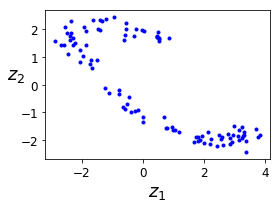

In [8]:
fig = plt.figure(figsize=(4,3))
plt.plot(codings_val[:,0], codings_val[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
save_fig("wykres_analizy_pca_z_autokodere_liniowym")
plt.show()

# Autokodery stosowe

Wykorzystajmy zbiór danych MNIST:

In [9]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/dane/")

Extracting /tmp/dane/train-images-idx3-ubyte.gz
Extracting /tmp/dane/train-labels-idx1-ubyte.gz
Extracting /tmp/dane/t10k-images-idx3-ubyte.gz
Extracting /tmp/dane/t10k-labels-idx1-ubyte.gz


## Jednoczesne uczenie wszystkich warstw

Zbudujmy autokoder stosowy zawierający trzy warstwy ukryte i jedną wyjściową (tj. dwa autokodery stosowe). Skorzystamy z funkcji aktywacji ELU, inicjacji He'ego i regularyzacji L2.

Uwaga: funkcja `tf.layers.dense()` jest niekompatybilna z używaną w książce funkcją `tf.contrib.layers.arg_scope()`, dlatego zastępujemy ją tutaj funkcją `functools.partial()`. Dzięki temu znacznie łatwiej będzie nam stworzyć funkcję `my_dense_layer()` mającą za zadanie jedynie wywoływanie funkcji `tf.layers.dense()` z określonymi, automatycznie wyznaczonymi parametrami (chyba,  że zostaną one przesłonięte podczas wywoływania funkcji `my_dense_layer()`).

In [10]:
reset_graph()

from functools import partial

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # kodwania
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0001

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

he_init = tf.contrib.layers.variance_scaling_initializer() # Inicjacja He`ego
#Równoznaczne wierszowi:
#he_init = lambda shape, dtype=tf.float32: tf.truncated_normal(shape, 0., stddev=np.sqrt(2/shape[0]))
l2_regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
my_dense_layer = partial(tf.layers.dense,
                         activation=tf.nn.elu,
                         kernel_initializer=he_init,
                         kernel_regularizer=l2_regularizer)

hidden1 = my_dense_layer(X, n_hidden1)
hidden2 = my_dense_layer(hidden1, n_hidden2)
hidden3 = my_dense_layer(hidden2, n_hidden3)
outputs = my_dense_layer(hidden3, n_outputs, activation=None)

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
loss = tf.add_n([reconstruction_loss] + reg_losses)

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver() # nieukazane w książce

Wyuczmy nasz model! Zwróć uwagę, że nie dostarczamy mu wartości docelowych (nie wykorzystujemy tensora `y_batch`). Mamy do czynienia z uczeniem nienadzorowanym.

In [11]:
n_epochs = 5
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="") # nieukazane w książce
            sys.stdout.flush()                                          # nieukazane
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})   # nieukazane
        print("\r{}".format(epoch), "Błąd MSE podczas uczenia:", loss_train)           # nieukazane
        saver.save(sess, "./moj_model_wszystkie_warstwy.ckpt")                  # nieukazane

0 Błąd MSE podczas uczenia: 0.0208554
1 %Błąd MSE podczas uczenia: 0.0113726
29% Błąd MSE podczas uczenia: 0.0102246
39% Błąd MSE podczas uczenia: 0.00990046
49% Błąd MSE podczas uczenia: 0.0103758


Poniższa funkcja wczytuje model, ocenia go przy użyciu zbioru testowego (mierzy błąd rekonstrukcji), a następnie wyświetla pierwotny rysunek i jego rekonstrukcję:

In [12]:
def show_reconstructed_digits(X, outputs, model_path = None, n_test_digits = 2):
    with tf.Session() as sess:
        if model_path:
            saver.restore(sess, model_path)
        X_test = mnist.test.images[:n_test_digits]
        outputs_val = outputs.eval(feed_dict={X: X_test})

    fig = plt.figure(figsize=(8, 3 * n_test_digits))
    for digit_index in range(n_test_digits):
        plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
        plot_image(X_test[digit_index])
        plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
        plot_image(outputs_val[digit_index])

INFO:tensorflow:Restoring parameters from ./moj_model_wszystkie_warstwy.ckpt
Zapisywanie rysunku wykres_rekonstrukcja


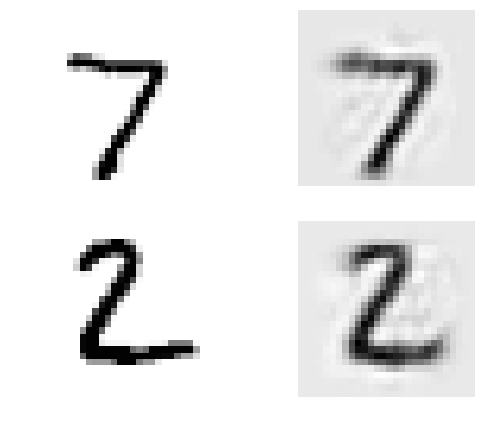

In [13]:
show_reconstructed_digits(X, outputs, "./moj_model_wszystkie_warstwy.ckpt")
save_fig("wykres_rekonstrukcja")

## Wiązanie wag

Powszechnym rozwiązaniem jest wiązanie wag kodera i dekodera (`weights_decoder = tf.transpose(weights_encoder)`). Niestety, uniemożliwia to (a przynajmniej znacznie utrudnia) korzystanie z funkcji `tf.layers.dense()`, dlatego musimy własnoręcznie stworzyć autokoder:

In [14]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # kodowania
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0005

In [15]:
activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="wagi1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="wagi2")
weights3 = tf.transpose(weights2, name="wagi3")  # powiązane wagi
weights4 = tf.transpose(weights1, name="wagi4")  # powiązane wagi

biases1 = tf.Variable(tf.zeros(n_hidden1), name="obciazenia1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="obciazenia2")
biases3 = tf.Variable(tf.zeros(n_hidden3), name="obciazenia3")
biases4 = tf.Variable(tf.zeros(n_outputs), name="obciazenia4")

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)
outputs = tf.matmul(hidden3, weights4) + biases4

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))
reg_loss = regularizer(weights1) + regularizer(weights2)
loss = reconstruction_loss + reg_loss

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [16]:
saver = tf.train.Saver()

In [17]:
n_epochs = 5
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Błąd MSE podczas uczenia:", loss_train)
        saver.save(sess, "./moj_model_wiazanie_wag.ckpt")

0 Błąd MSE podczas uczenia: 0.0150667
19% Błąd MSE podczas uczenia: 0.0164884
29% Błąd MSE podczas uczenia: 0.0173757
3 Błąd MSE podczas uczenia: 0.0168781
4 Błąd MSE podczas uczenia: 0.0155875


INFO:tensorflow:Restoring parameters from ./moj_model_wiazanie_wag.ckpt


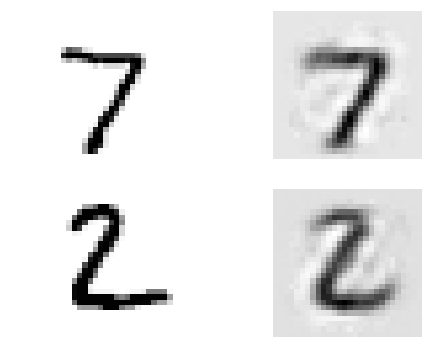

In [18]:
show_reconstructed_digits(X, outputs, "./moj_model_wiazanie_wag.ckpt")

## Uczenie autokoderów pojedynczo na wielu grafach

Istnieje wiele sposobów uczenia autokoderów pojedynczo. Pierwszym rozwiązaniem jest trenowanie każdego autokodera korzystając z osobnych grafów, a następnie utworzenie autokodera stosowego poprzez zainicjowanie go za pomocą wag i obciążeń uzyskanych dla poszczególnych autokoderów składowych.

Stwórzmy funkcję, która wyuczy jeden autokoder i zwróci przekształcony zbiór uczący (tzn. wynik warstwy ukrytej) i parametry modelu.

In [19]:
reset_graph()

from functools import partial

def train_autoencoder(X_train, n_neurons, n_epochs, batch_size,
                      learning_rate = 0.01, l2_reg = 0.0005, seed=42,
                      hidden_activation=tf.nn.elu,
                      output_activation=tf.nn.elu):
    graph = tf.Graph()
    with graph.as_default():
        tf.set_random_seed(seed)

        n_inputs = X_train.shape[1]

        X = tf.placeholder(tf.float32, shape=[None, n_inputs])
        
        my_dense_layer = partial(
            tf.layers.dense,
            kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
            kernel_regularizer=tf.contrib.layers.l2_regularizer(l2_reg))

        hidden = my_dense_layer(X, n_neurons, activation=hidden_activation, name="ukryta")
        outputs = my_dense_layer(hidden, n_inputs, activation=output_activation, name="wyjscia")

        reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

        reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
        loss = tf.add_n([reconstruction_loss] + reg_losses)

        optimizer = tf.train.AdamOptimizer(learning_rate)
        training_op = optimizer.minimize(loss)

        init = tf.global_variables_initializer()

    with tf.Session(graph=graph) as sess:
        init.run()
        for epoch in range(n_epochs):
            n_batches = len(X_train) // batch_size
            for iteration in range(n_batches):
                print("\r{}%".format(100 * iteration // n_batches), end="")
                sys.stdout.flush()
                indices = rnd.permutation(len(X_train))[:batch_size]
                X_batch = X_train[indices]
                sess.run(training_op, feed_dict={X: X_batch})
            loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
            print("\r{}".format(epoch), "Błąd MSE podczas uczenia:", loss_train)
        params = dict([(var.name, var.eval()) for var in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)])
        hidden_val = hidden.eval(feed_dict={X: X_train})
        return hidden_val, params["ukryta/kernel:0"], params["ukryta/bias:0"], params["wyjscia/kernel:0"], params["wyjscia/bias:0"]

Wyuczmy teraz dwa autokodery. Pierwszy z nich wytrenujemy za pomocą danych uczących, natomiast do nauki drugiego wykorzystamy wynik warstwy ukrytej z pierwszego autokodera:

In [20]:
hidden_output, W1, b1, W4, b4 = train_autoencoder(mnist.train.images, n_neurons=300, n_epochs=4, batch_size=150,
                                                  output_activation=None)
_, W2, b2, W3, b3 = train_autoencoder(hidden_output, n_neurons=150, n_epochs=4, batch_size=150)

0 Błąd MSE podczas uczenia: 0.0185175
19% Błąd MSE podczas uczenia: 0.0186825
2 Błąd MSE podczas uczenia: 0.0184675
39% Błąd MSE podczas uczenia: 0.0192315
09% Błąd MSE podczas uczenia: 0.0042361
19% Błąd MSE podczas uczenia: 0.00483266
2 %Błąd MSE podczas uczenia: 0.00466872
3 Błąd MSE podczas uczenia: 0.00440389


W końcu możemy stworzyć autokoder stosowy wykorzystując wagi i obciążenia dopiero co wyuczonych autokoderów:

In [21]:
reset_graph()

n_inputs = 28*28

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden1 = tf.nn.elu(tf.matmul(X, W1) + b1)
hidden2 = tf.nn.elu(tf.matmul(hidden1, W2) + b2)
hidden3 = tf.nn.elu(tf.matmul(hidden2, W3) + b3)
outputs = tf.matmul(hidden3, W4) + b4

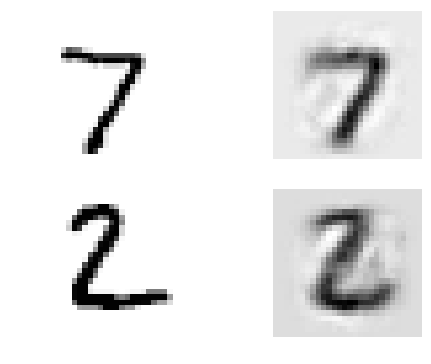

In [22]:
show_reconstructed_digits(X, outputs)

## Uczenie autokoderów pojedynczo na jednym grafie

Innym sposobem jest wykorzystanie pojedynczego grafu. W tym celu tworzymy graf dla pełnego autokodera stosowego, ale dodajemy również operacje pozwalające na niezależne trenowanie każdego autokodera stosowego: operacje pierwszej fazy uczą dolną i górną warstwę (pierwszy autokoder), natomiast operacje drugiej fazy przeprowadzają proces uczenia dwóch środkowych warstw (drugiego autokodera).

In [23]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # kodowania
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0001

activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])
weights3_init = initializer([n_hidden2, n_hidden3])
weights4_init = initializer([n_hidden3, n_outputs])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="wagi1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="wagi2")
weights3 = tf.Variable(weights3_init, dtype=tf.float32, name="wagi3")
weights4 = tf.Variable(weights4_init, dtype=tf.float32, name="wagi4")

biases1 = tf.Variable(tf.zeros(n_hidden1), name="obciazenia1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="obciazenia2")
biases3 = tf.Variable(tf.zeros(n_hidden3), name="obciazenia3")
biases4 = tf.Variable(tf.zeros(n_outputs), name="obciazenia4")

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)
outputs = tf.matmul(hidden3, weights4) + biases4

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

In [24]:
optimizer = tf.train.AdamOptimizer(learning_rate)

with tf.name_scope("faza1"):
    phase1_outputs = tf.matmul(hidden1, weights4) + biases4  # pomija warstwy ukryta2 i ukryta3
    phase1_reconstruction_loss = tf.reduce_mean(tf.square(phase1_outputs - X))
    phase1_reg_loss = regularizer(weights1) + regularizer(weights4)
    phase1_loss = phase1_reconstruction_loss + phase1_reg_loss
    phase1_training_op = optimizer.minimize(phase1_loss)

with tf.name_scope("faza2"):
    phase2_reconstruction_loss = tf.reduce_mean(tf.square(hidden3 - hidden1))
    phase2_reg_loss = regularizer(weights2) + regularizer(weights3)
    phase2_loss = phase2_reconstruction_loss + phase2_reg_loss
    train_vars = [weights2, biases2, weights3, biases3]
    phase2_training_op = optimizer.minimize(phase2_loss, var_list=train_vars) # zamraża warstwę ukryta1

In [25]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [26]:
training_ops = [phase1_training_op, phase2_training_op]
reconstruction_losses = [phase1_reconstruction_loss, phase2_reconstruction_loss]
n_epochs = [4, 4]
batch_sizes = [150, 150]

with tf.Session() as sess:
    init.run()
    for phase in range(2):
        print("Faza uczenia #{}".format(phase + 1))
        for epoch in range(n_epochs[phase]):
            n_batches = mnist.train.num_examples // batch_sizes[phase]
            for iteration in range(n_batches):
                print("\r{}%".format(100 * iteration // n_batches), end="")
                sys.stdout.flush()
                X_batch, y_batch = mnist.train.next_batch(batch_sizes[phase])
                sess.run(training_ops[phase], feed_dict={X: X_batch})
            loss_train = reconstruction_losses[phase].eval(feed_dict={X: X_batch})
            print("\r{}".format(epoch), "Błąd MSE podczas uczenia:", loss_train)
            saver.save(sess, "./moj_model_uczenie_pojedynczo.ckpt")
    loss_test = reconstruction_loss.eval(feed_dict={X: mnist.test.images})
    print("Błąd MSE podczas testowania:", loss_test)

Faza uczenia #1
09% Błąd MSE podczas uczenia: 0.00740679
19% Błąd MSE podczas uczenia: 0.00782866
29% Błąd MSE podczas uczenia: 0.00772802
3 Błąd MSE podczas uczenia: 0.00740893
Faza uczenia #2
0 Błąd MSE podczas uczenia: 0.235318
1 Błąd MSE podczas uczenia: 0.00593943
29% Błąd MSE podczas uczenia: 0.00294401
39% Błąd MSE podczas uczenia: 0.00242355
Błąd MSE podczas testowania: 0.00978226


## Buforowanie wyników zamrożonej warstwy 

In [27]:
training_ops = [phase1_training_op, phase2_training_op]
reconstruction_losses = [phase1_reconstruction_loss, phase2_reconstruction_loss]
n_epochs = [4, 4]
batch_sizes = [150, 150]

with tf.Session() as sess:
    init.run()
    for phase in range(2):
        print("Faza uczenia #{}".format(phase + 1))
        if phase == 1:
            hidden1_cache = hidden1.eval(feed_dict={X: mnist.train.images})
        for epoch in range(n_epochs[phase]):
            n_batches = mnist.train.num_examples // batch_sizes[phase]
            for iteration in range(n_batches):
                print("\r{}%".format(100 * iteration // n_batches), end="")
                sys.stdout.flush()
                if phase == 1:
                    indices = rnd.permutation(mnist.train.num_examples)
                    hidden1_batch = hidden1_cache[indices[:batch_sizes[phase]]]
                    feed_dict = {hidden1: hidden1_batch}
                    sess.run(training_ops[phase], feed_dict=feed_dict)
                else:
                    X_batch, y_batch = mnist.train.next_batch(batch_sizes[phase])
                    feed_dict = {X: X_batch}
                    sess.run(training_ops[phase], feed_dict=feed_dict)
            loss_train = reconstruction_losses[phase].eval(feed_dict=feed_dict)
            print("\r{}".format(epoch), "Błąd MSE podczas uczenia:", loss_train)
            saver.save(sess, "./moj_model_buforowanie_zamrozonej.ckpt")
    loss_test = reconstruction_loss.eval(feed_dict={X: mnist.test.images})
    print("Błąd MSE podczas testowania:", loss_test)

Faza uczenia #1
09% Błąd MSE podczas uczenia: 0.00753817
1 Błąd MSE podczas uczenia: 0.00775457
2 Błąd MSE podczas uczenia: 0.00734359
39% Błąd MSE podczas uczenia: 0.00783768
Faza uczenia #2
09% Błąd MSE podczas uczenia: 0.117372
19% Błąd MSE podczas uczenia: 0.0045125
2 Błąd MSE podczas uczenia: 0.00239339
39% Błąd MSE podczas uczenia: 0.00202585
Błąd MSE podczas testowania: 0.0097551


## Wizualizowanie rekonstrukcji

INFO:tensorflow:Restoring parameters from ./moj_model_uczenie_pojedynczo.ckpt


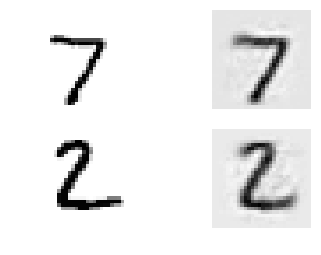

In [28]:
n_test_digits = 2
X_test = mnist.test.images[:n_test_digits]

with tf.Session() as sess:
    saver.restore(sess, "./moj_model_uczenie_pojedynczo.ckpt") # nieukazane w książce
    outputs_val = outputs.eval(feed_dict={X: X_test})

def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")
    plt.axis("off")

for digit_index in range(n_test_digits):
    plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
    plot_image(X_test[digit_index])
    plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
    plot_image(outputs_val[digit_index])

## Wizualizowanie wydobytych cech

INFO:tensorflow:Restoring parameters from ./moj_model_uczenie_pojedynczo.ckpt
Zapisywanie rysunku wykres_wydobyte_cechy


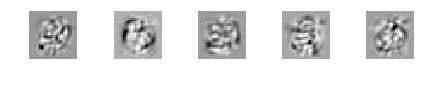

In [29]:
with tf.Session() as sess:
    saver.restore(sess, "./moj_model_uczenie_pojedynczo.ckpt") # nieukazane w książce
    weights1_val = weights1.eval()

for i in range(5):
    plt.subplot(1, 5, i + 1)
    plot_image(weights1_val.T[i])

save_fig("wykres_wydobyte_cechy") # nieukazane
plt.show()                          # nieukazane

# Nienadzorowane uczenie wstępne

Stwórzmy niewielką sieć neuronową służącą do klasyfikowania obrazów MNIST:

In [30]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150
n_outputs = 10

learning_rate = 0.01
l2_reg = 0.0005

activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
y = tf.placeholder(tf.int32, shape=[None])

weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])
weights3_init = initializer([n_hidden2, n_outputs])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="wagi1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="wagi2")
weights3 = tf.Variable(weights3_init, dtype=tf.float32, name="wagi3")

biases1 = tf.Variable(tf.zeros(n_hidden1), name="obciazenia1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="obciazenia2")
biases3 = tf.Variable(tf.zeros(n_outputs), name="obciazenia3")

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
logits = tf.matmul(hidden2, weights3) + biases3

cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
reg_loss = regularizer(weights1) + regularizer(weights2) + regularizer(weights3)
loss = cross_entropy + reg_loss
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
pretrain_saver = tf.train.Saver([weights1, weights2, biases1, biases2])
saver = tf.train.Saver()

Standardowy trening (bez uczenia wstępnego):

In [31]:
n_epochs = 4
batch_size = 150
n_labeled_instances = 20000

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = n_labeled_instances // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            indices = rnd.permutation(n_labeled_instances)[:batch_size]
            X_batch, y_batch = mnist.train.images[indices], mnist.train.labels[indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        print("\r{}".format(epoch), "Dokładność dla zbioru uczącego:", accuracy_val, end=" ")
        saver.save(sess, "./moj_model_nadzorowany.ckpt")
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images, y: mnist.test.labels})
        print("Dokładność dla zbioru testowego:", accuracy_val)

09% Dokładność dla zbioru uczącego: 0.973333 Dokładność dla zbioru testowego: 0.9334
19% Dokładność dla zbioru uczącego: 0.98 Dokładność dla zbioru testowego: 0.936
29% Dokładność dla zbioru uczącego: 0.973333 Dokładność dla zbioru testowego: 0.9382
39% Dokładność dla zbioru uczącego: 0.986667 Dokładność dla zbioru testowego: 0.9492


Teraz ponownie użyjemy dwóch pierwszych warstw z powyższego, wstępnie wyuczonego autokodera:

In [32]:
n_epochs = 4
batch_size = 150
n_labeled_instances = 20000

#training_op = optimizer.minimize(loss, var_list=[weights3, biases3])  # zamraża pierwszą i drugą warstwę (dodatkowe)

with tf.Session() as sess:
    init.run()
    pretrain_saver.restore(sess, "./moj_model_buforowanie_zamrozonej.ckpt")
    for epoch in range(n_epochs):
        n_batches = n_labeled_instances // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            indices = rnd.permutation(n_labeled_instances)[:batch_size]
            X_batch, y_batch = mnist.train.images[indices], mnist.train.labels[indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        print("\r{}".format(epoch), "Dokładność dla zbioru uczącego:", accuracy_val, end="\t")
        saver.save(sess, "./moj_model_nadzorowany_uczenie_wstepne.ckpt")
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images, y: mnist.test.labels})
        print("Dokładność dla zbioru testowego:", accuracy_val)

INFO:tensorflow:Restoring parameters from ./moj_model_buforowanie_zamrozonej.ckpt
0 Dokładność dla zbioru uczącego: 0.966667	Dokładność dla zbioru testowego: 0.9308
19% Dokładność dla zbioru uczącego: 0.96	Dokładność dla zbioru testowego: 0.9328
29% Dokładność dla zbioru uczącego: 0.973333	Dokładność dla zbioru testowego: 0.9414
3 Dokładność dla zbioru uczącego: 0.966667	Dokładność dla zbioru testowego: 0.9484


# Odszumiający autokoder stosowy

Uwaga: w książce jest używana funkcja `tf.contrib.layers.dropout()` zamiast funkcji `tf.layers.dropout()` (która nie istniała w czasie pisania tego rozdziału). Zalecane jest korzystanie z funkcji `tf.layers.dropout()`, ponieważ wszystkie składniki modułu `contrib` mogą być modyfikowane lub usuwane bez zapowiedzi. Funkcja `tf.layers.dropout()` niemal niczym nie różni się od funkcji `tf.contrib.layers.dropout()`, nie licząc kilku niewielkich zmian. Najważniejsze z nich to:
* musisz określić współczynnik porzucania (`rate`), a nie prawdopodobieństwo pozostawiania neuronów (`keep_prob`), gdzie `rate` to po prostu `1 - keep_prob`,
* parametr `is_training` został przemianowany na `training`.

Wprowadzamy szum gaussowski:

In [33]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # kodowania
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01

In [34]:
noise_level = 1.0

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
X_noisy = X + noise_level * tf.random_normal(tf.shape(X))

hidden1 = tf.layers.dense(X_noisy, n_hidden1, activation=tf.nn.relu,
                          name="ukryta1")
hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, # nieukazane w książce
                          name="ukryta2")                            # nieukazane
hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, # nieukazane
                          name="ukryta3")                            # nieukazane
outputs = tf.layers.dense(hidden3, n_outputs, name="wyjscia")        # nieukazane

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X)) # błąd MSE

In [35]:
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [36]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Błąd MSE podczas uczenia:", loss_train)
        saver.save(sess, "./moj_odszumiajacy_model_stosowy_szum_gaussowski.ckpt")

09% Błąd MSE podczas uczenia: 0.0438934
19% Błąd MSE podczas uczenia: 0.0429818
2 Błąd MSE podczas uczenia: 0.0420282
39% Błąd MSE podczas uczenia: 0.0407662
49% Błąd MSE podczas uczenia: 0.0400326
59% Błąd MSE podczas uczenia: 0.0390536
6 Błąd MSE podczas uczenia: 0.0401434
7 Błąd MSE podczas uczenia: 0.0422726
8 %Błąd MSE podczas uczenia: 0.0400669
99% Błąd MSE podczas uczenia: 0.041025


Wprowadzamy porzucanie:

In [37]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # kodowania
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01

In [38]:
dropout_rate = 0.3

training = tf.placeholder_with_default(False, shape=(), name='uczenie')

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
X_drop = tf.layers.dropout(X, dropout_rate, training=training)

hidden1 = tf.layers.dense(X_drop, n_hidden1, activation=tf.nn.relu,
                          name="ukryta1")
hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, # nieukazane w książce
                          name="ukryta2")                            # nieukazane
hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, # nieukazane
                          name="ukryta3")                            # nieukazane
outputs = tf.layers.dense(hidden3, n_outputs, name="wyjscia")        # nieukazane

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X)) # błąd MSE

In [39]:
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [40]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, training: True})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Błąd MSE podczas uczenia:", loss_train)
        saver.save(sess, "./moj_odszumiający_model_stosowy_porzucanie.ckpt")

0 Błąd MSE podczas uczenia: 0.0296476
1 Błąd MSE podczas uczenia: 0.0275545
2 Błąd MSE podczas uczenia: 0.0250731
3 Błąd MSE podczas uczenia: 0.0254317
4 Błąd MSE podczas uczenia: 0.0249076
5 Błąd MSE podczas uczenia: 0.0250501
6 Błąd MSE podczas uczenia: 0.024483
7 Błąd MSE podczas uczenia: 0.0251505
8 Błąd MSE podczas uczenia: 0.0243836
9 Błąd MSE podczas uczenia: 0.0242349


INFO:tensorflow:Restoring parameters from ./moj_odszumiający_model_stosowy_porzucanie.ckpt


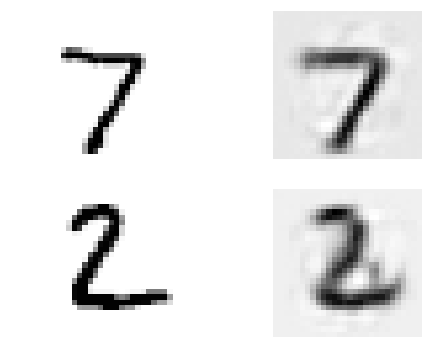

In [41]:
show_reconstructed_digits(X, outputs, "./moj_odszumiający_model_stosowy_porzucanie.ckpt")

# Autokoder rozrzedzający

Zapisywanie rysunku wykres_rzadkość_koszt


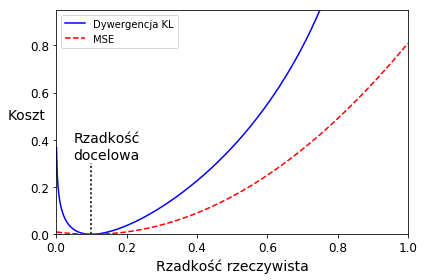

In [42]:
p = 0.1
q = np.linspace(0.001, 0.999, 500)
kl_div = p * np.log(p / q) + (1 - p) * np.log((1 - p) / (1 - q))
mse = (p - q)**2
plt.plot([p, p], [0, 0.3], "k:")
plt.text(0.05, 0.32, "Rzadkość\ndocelowa", fontsize=14)
plt.plot(q, kl_div, "b-", label="Dywergencja KL")
plt.plot(q, mse, "r--", label="MSE")
plt.legend(loc="upper left")
plt.xlabel("Rzadkość rzeczywista")
plt.ylabel("Koszt", rotation=0)
plt.axis([0, 1, 0, 0.95])
save_fig("wykres_rzadkość_koszt")

In [43]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 1000  # rzadkie kodowania
n_outputs = n_inputs

In [44]:
def kl_divergence(p, q):
    # Dywergencja Kullbacka-Leiblera
    return p * tf.log(p / q) + (1 - p) * tf.log((1 - p) / (1 - q))

learning_rate = 0.01
sparsity_target = 0.1
sparsity_weight = 0.2

X = tf.placeholder(tf.float32, shape=[None, n_inputs])            # nieukazane w książce

hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.sigmoid) # nieukazane
outputs = tf.layers.dense(hidden1, n_outputs)                     # nieukazane

hidden1_mean = tf.reduce_mean(hidden1, axis=0) # średnia grupy
sparsity_loss = tf.reduce_sum(kl_divergence(sparsity_target, hidden1_mean))
reconstruction_loss = tf.reduce_mean(tf.square(outputs - X)) # błąd MSE
loss = reconstruction_loss + sparsity_weight * sparsity_loss

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

In [45]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [48]:
n_epochs = 100
batch_size = 1000

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        reconstruction_loss_val, sparsity_loss_val, loss_val = sess.run([reconstruction_loss, sparsity_loss, loss], feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Błąd MSE podczas uczenia:", reconstruction_loss_val, "\tF. straty rzadkości:", sparsity_loss_val, "\tCałkowita funkcja straty:", loss_val)
        saver.save(sess, "./moj_model_rozrzedzajacy.ckpt")

0 Błąd MSE podczas uczenia: 0.123632 	F. straty rzadkości: 0.420973 	Całkowita funkcja straty: 0.207826
1 Błąd MSE podczas uczenia: 0.0601524 	F. straty rzadkości: 0.286534 	Całkowita funkcja straty: 0.117459
2 Błąd MSE podczas uczenia: 0.0514993 	F. straty rzadkości: 0.116399 	Całkowita funkcja straty: 0.074779
3 Błąd MSE podczas uczenia: 0.0479883 	F. straty rzadkości: 0.0265944 	Całkowita funkcja straty: 0.0533072
4 Błąd MSE podczas uczenia: 0.044873 	F. straty rzadkości: 0.0652213 	Całkowita funkcja straty: 0.0579173
5 Błąd MSE podczas uczenia: 0.0419816 	F. straty rzadkości: 0.245253 	Całkowita funkcja straty: 0.0910321
6 Błąd MSE podczas uczenia: 0.0381512 	F. straty rzadkości: 0.0776636 	Całkowita funkcja straty: 0.0536839
7 Błąd MSE podczas uczenia: 0.0359831 	F. straty rzadkości: 0.0271819 	Całkowita funkcja straty: 0.0414194
8 Błąd MSE podczas uczenia: 0.033074 	F. straty rzadkości: 0.0349997 	Całkowita funkcja straty: 0.040074
9 Błąd MSE podczas uczenia: 0.0303832 	F. straty

INFO:tensorflow:Restoring parameters from ./moj_model_rozrzedzajacy.ckpt


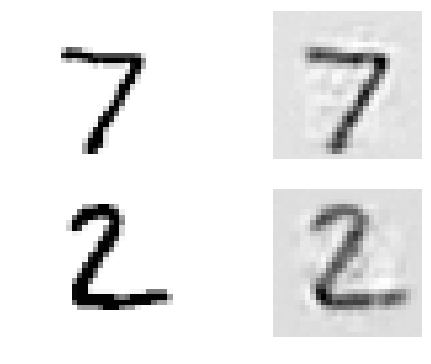

In [49]:
show_reconstructed_digits(X, outputs, "./moj_model_rozrzedzajacy.ckpt")

Zwróc uwagę, że warstwa kodowania musi dawać na wyjściu wartości w zakresie od 0 do 1, dlatego właśnie stosujemy sigmoidalną funkcję aktywacji:

In [50]:
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.sigmoid)

Aby przyśpieszyć proces uczenia, możemy znormalizować dane wejściowe do zakresu wartości od 0 do 1 i zastąpić błąd MSE entropią krzyżową jako funkcją kosztu:

In [51]:
logits = tf.layers.dense(hidden1, n_outputs)
outputs = tf.nn.sigmoid(logits)

xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=X, logits=logits)
reconstruction_loss = tf.reduce_mean(xentropy)

# Autokoder wariacyjny

In [52]:
reset_graph()

from functools import partial

n_inputs = 28 * 28
n_hidden1 = 500
n_hidden2 = 500
n_hidden3 = 20  # kodowania
n_hidden4 = n_hidden2
n_hidden5 = n_hidden1
n_outputs = n_inputs
learning_rate = 0.001

initializer = tf.contrib.layers.variance_scaling_initializer()

my_dense_layer = partial(
    tf.layers.dense,
    activation=tf.nn.elu,
    kernel_initializer=initializer)

X = tf.placeholder(tf.float32, [None, n_inputs])
hidden1 = my_dense_layer(X, n_hidden1)
hidden2 = my_dense_layer(hidden1, n_hidden2)
hidden3_mean = my_dense_layer(hidden2, n_hidden3, activation=None)
hidden3_sigma = my_dense_layer(hidden2, n_hidden3, activation=None)
noise = tf.random_normal(tf.shape(hidden3_sigma), dtype=tf.float32)
hidden3 = hidden3_mean + hidden3_sigma * noise
hidden4 = my_dense_layer(hidden3, n_hidden4)
hidden5 = my_dense_layer(hidden4, n_hidden5)
logits = my_dense_layer(hidden5, n_outputs, activation=None)
outputs = tf.sigmoid(logits)

xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=X, logits=logits)
reconstruction_loss = tf.reduce_sum(xentropy)

In [53]:
eps = 1e-10 # człon wyrównujący pozwalający uniknąć wyliczania log(0), czyli wartości NaN
latent_loss = 0.5 * tf.reduce_sum(
    tf.square(hidden3_sigma) + tf.square(hidden3_mean)
    - 1 - tf.log(eps + tf.square(hidden3_sigma)))

In [54]:
loss = reconstruction_loss + latent_loss

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [55]:
n_epochs = 50
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_val, reconstruction_loss_val, latent_loss_val = sess.run([loss, reconstruction_loss, latent_loss], feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Całkowita strata podczas uczenia:", loss_val, "\tStrata rekonstrukcji:", reconstruction_loss_val, "\tStrata ukryta:", latent_loss_val)
        saver.save(sess, "./moj_model_wariacyjny.ckpt")

0 Całkowita strata podczas uczenia: 30921.2 	Strata rekonstrukcji: 24138.1 	Strata ukryta: 6783.14
1 Całkowita strata podczas uczenia: 26830.0 	Strata rekonstrukcji: 23252.3 	Strata ukryta: 3577.71
29% Całkowita strata podczas uczenia: 31506.2 	Strata rekonstrukcji: 26147.8 	Strata ukryta: 5358.43
39% Całkowita strata podczas uczenia: 34099.1 	Strata rekonstrukcji: 26747.2 	Strata ukryta: 7351.91
4 Całkowita strata podczas uczenia: 21395.1 	Strata rekonstrukcji: 18219.9 	Strata ukryta: 3175.27
5 Całkowita strata podczas uczenia: 20163.7 	Strata rekonstrukcji: 17029.6 	Strata ukryta: 3134.1
6 Całkowita strata podczas uczenia: 19946.8 	Strata rekonstrukcji: 17121.0 	Strata ukryta: 2825.76
7 Całkowita strata podczas uczenia: 17970.6 	Strata rekonstrukcji: 14859.6 	Strata ukryta: 3110.98
8 Całkowita strata podczas uczenia: 16951.6 	Strata rekonstrukcji: 13843.5 	Strata ukryta: 3108.14
9 Całkowita strata podczas uczenia: 16869.0 	Strata rekonstrukcji: 13557.6 	Strata ukryta: 3311.44
10 Całk

In [ ]:
reset_graph()

from functools import partial

n_inputs = 28 * 28
n_hidden1 = 500
n_hidden2 = 500
n_hidden3 = 20  # kodowania
n_hidden4 = n_hidden2
n_hidden5 = n_hidden1
n_outputs = n_inputs
learning_rate = 0.001

initializer = tf.contrib.layers.variance_scaling_initializer()
my_dense_layer = partial(
    tf.layers.dense,
    activation=tf.nn.elu,
    kernel_initializer=initializer)

X = tf.placeholder(tf.float32, [None, n_inputs])
hidden1 = my_dense_layer(X, n_hidden1)
hidden2 = my_dense_layer(hidden1, n_hidden2)
hidden3_mean = my_dense_layer(hidden2, n_hidden3, activation=None)
hidden3_gamma = my_dense_layer(hidden2, n_hidden3, activation=None)
noise = tf.random_normal(tf.shape(hidden3_gamma), dtype=tf.float32)
hidden3 = hidden3_mean + tf.exp(0.5 * hidden3_gamma) * noise
hidden4 = my_dense_layer(hidden3, n_hidden4)
hidden5 = my_dense_layer(hidden4, n_hidden5)
logits = my_dense_layer(hidden5, n_outputs, activation=None)
outputs = tf.sigmoid(logits)

xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=X, logits=logits)
reconstruction_loss = tf.reduce_sum(xentropy)
latent_loss = 0.5 * tf.reduce_sum(
    tf.exp(hidden3_gamma) + tf.square(hidden3_mean) - 1 - hidden3_gamma)
loss = reconstruction_loss + latent_loss

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

## Generowanie cyfr

Wyuczmy model i wygenerujmy kilka losowych cyfr:

In [ ]:
import numpy as np

n_digits = 60
n_epochs = 50
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="") # nieukazane w książce
            sys.stdout.flush()                                          # nieukazane
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_val, reconstruction_loss_val, latent_loss_val = sess.run([loss, reconstruction_loss, latent_loss], feed_dict={X: X_batch}) # not shown
        print("\r{}".format(epoch), "Całkowita strata podczas uczenia:", loss_val, "\tStrata rekonstrukcji:", reconstruction_loss_val, "\tStrata ukryta:", latent_loss_val)  # not shown
        saver.save(sess, "./moj_model_wariacyjny.ckpt")  # nieukazane
    
    codings_rnd = np.random.normal(size=[n_digits, n_hidden3])
    outputs_val = outputs.eval(feed_dict={hidden3: codings_rnd})

0 Całkowita strata podczas uczenia: 18327.1 	Strata rekonstrukcji: 14609.7 	Strata ukryta: 3717.39
1 Całkowita strata podczas uczenia: 17083.5 	Strata rekonstrukcji: 13292.2 	Strata ukryta: 3791.22
2 Całkowita strata podczas uczenia: 16554.0 	Strata rekonstrukcji: 12817.5 	Strata ukryta: 3736.45
3 Całkowita strata podczas uczenia: 16694.2 	Strata rekonstrukcji: 12873.4 	Strata ukryta: 3820.72
4 Całkowita strata podczas uczenia: 15828.2 	Strata rekonstrukcji: 12186.9 	Strata ukryta: 3641.32
59% Całkowita strata podczas uczenia: 16306.7 	Strata rekonstrukcji: 12531.5 	Strata ukryta: 3775.27
6 Całkowita strata podczas uczenia: 15834.7 	Strata rekonstrukcji: 11992.1 	Strata ukryta: 3842.51
7 %Całkowita strata podczas uczenia: 15995.3 	Strata rekonstrukcji: 12217.9 	Strata ukryta: 3777.4
8 Całkowita strata podczas uczenia: 15838.0 	Strata rekonstrukcji: 12065.3 	Strata ukryta: 3772.66
9 Całkowita strata podczas uczenia: 14754.3 	Strata rekonstrukcji: 11051.5 	Strata ukryta: 3702.85
10 Całko

In [ ]:
plt.figure(figsize=(8,50)) # nieukazane w książce
for iteration in range(n_digits):
    plt.subplot(n_digits, 10, iteration + 1)
    plot_image(outputs_val[iteration])

In [ ]:
n_rows = 6
n_cols = 10
plot_multiple_images(outputs_val.reshape(-1, 28, 28), n_rows, n_cols)
save_fig("wykres_wygenerowanych_cyfr")
plt.show()

Zauważ, że w tym drugim przypadku strata ukryta jest wyliczana w inny sposób:

In [ ]:
latent_loss = 0.5 * tf.reduce_sum(
    tf.exp(hidden3_gamma) + tf.square(hidden3_mean) - 1 - hidden3_gamma)

## Kodowanie i dekodowanie

Kodowanie:

In [ ]:
n_digits = 3
X_test, y_test = mnist.test.next_batch(batch_size)
codings = hidden3

with tf.Session() as sess:
    saver.restore(sess, "./moj_model_wariacyjny.ckpt")
    codings_val = codings.eval(feed_dict={X: X_test})

Dekodowanie:

In [ ]:
with tf.Session() as sess:
    saver.restore(sess, "./moj_model_wariacyjny.ckpt")
    outputs_val = outputs.eval(feed_dict={codings: codings_val})

Zwizualizujmy rekonstrukcje:

In [ ]:
fig = plt.figure(figsize=(8, 2.5 * n_digits))
for iteration in range(n_digits):
    plt.subplot(n_digits, 2, 1 + 2 * iteration)
    plot_image(X_test[iteration])
    plt.subplot(n_digits, 2, 2 + 2 * iteration)
    plot_image(outputs_val[iteration])

## Interpolacja cyfr

In [ ]:
n_iterations = 3
n_digits = 6
codings_rnd = np.random.normal(size=[n_digits, n_hidden3])

with tf.Session() as sess:
    saver.restore(sess, "./moj_model_wariacyjny.ckpt")
    target_codings = np.roll(codings_rnd, -1, axis=0)
    for iteration in range(n_iterations + 1):
        codings_interpolate = codings_rnd + (target_codings - codings_rnd) * iteration / n_iterations
        outputs_val = outputs.eval(feed_dict={codings: codings_interpolate})
        plt.figure(figsize=(11, 1.5*n_iterations))
        for digit_index in range(n_digits):
            plt.subplot(1, n_digits, digit_index + 1)
            plot_image(outputs_val[digit_index])
        plt.show()

# Rozwiązania ćwiczeń

Wkrótce...